In [12]:
# Add the parent directory to the path so that we can import the src module
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [13]:
from src.camera import CameraCalibration, Camera, CameraPose
from src.camera.video import VideoStream
from src.segmentation.circledetector import CircleDetector
from src.segmentation.likelyregion import get_high_probability_region
from src.pose.position_estimation import PositionEstimation
from src.ukf import BallUKF
from src.ukf.measurement import PositionMeasurementMode
from src.pingpong.ball import BallConstants
from src.pingpong.table import TableConstants
from src.fileutils import DATA_DIR
import src.visualization.plot3D as plot3D

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from scipy.spatial.transform import Rotation

In [14]:
# Define constants
CALIBRATION_VIDEO_PATH = DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV'
VIDEO_PATH = DATA_DIR / "videos" / "IMG_5385.MOV"

BALL = BallConstants()
TABLE = TableConstants()

CAMERA_POSITION = np.array([0, -(TABLE.net_width + 2), 0.5])
CAMERA_ORIENTATION = Rotation.from_euler('xyz', [-90, 0, 0], degrees=True)
CAMERA_MIRROR_Y = False


In [15]:
# Get camera calibration
calibration_video = VideoStream(DATA_DIR / 'calibration' / 'Priyanshu_iPhone13.MOV')
print(calibration_video)
calibration = CameraCalibration.from_calibration_video(tqdm(calibration_video, total=calibration_video.get_length_if_known()))
calibration.intrinsic_matrix

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\calibration\Priyanshu_iPhone13.MOV
	FPS: 212.2765805331427
	Frames: 866
	Resolution: 1920x1080



100%|██████████| 866/866 [00:25<00:00, 34.53it/s]


array([[     1773.6,           0,      911.76],
       [          0,        2188,      544.32],
       [          0,           0,           1]])

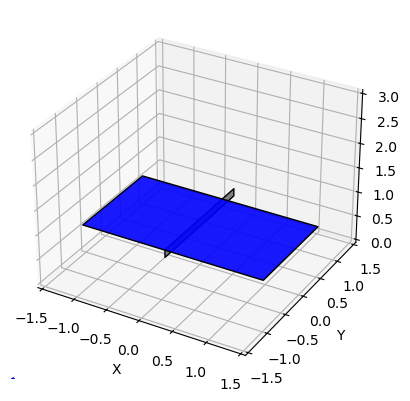

In [16]:
# Initialize camera
camera_pose = CameraPose(CAMERA_POSITION, CAMERA_ORIENTATION, mirror_y=CAMERA_MIRROR_Y)
camera = Camera(camera_pose, calibration)

# Plot the camera
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plot3D.plot_table(ax, TABLE)
plot3D.plot_camera(ax, camera)

In [17]:

# Initialize position estimator and circle detector
position_estimator = PositionEstimation(camera, BALL, TABLE)
circle_detector = CircleDetector()

position_estimator.project_ball_position_table_reference_frame_to_camera_plane(np.array([0, -3, 1]))

(912, 544, 39)

In [18]:
# Load video 
video = VideoStream(VIDEO_PATH)
video

VideoStream:
	Source: C:\Users\agpri\OneDrive\Documents\GitHub\PingPongTracking\data\videos\IMG_5385.MOV
	FPS: 26.625
	Frames: 213
	Resolution: 1920x1080

In [19]:
# Initialize Kalman Filter

# Initial state is all zeros with very high covariance
initial_state = np.zeros(12)   
initial_covariance = np.eye(12) * 1

# Process noise should be relatively small
process_noise = np.eye(12) * 0.1

# Measurement noise should be relatively large
measurement_noise = np.eye(3) * 0.3
measurement_mode = PositionMeasurementMode(measurement_noise)


ukf = BallUKF(BALL, initial_state, initial_covariance, process_noise, measurement_mode)

In [20]:
# Ball will at least be 1 meter away from the camera
_, _, max_diameter = position_estimator.project_ball_position_camera_reference_frame_to_camera_plane(np.array([0, 0, 1]))
max_radius = max_diameter // 2

6 9
No circles found in frame 0, skipping ukf update this frame


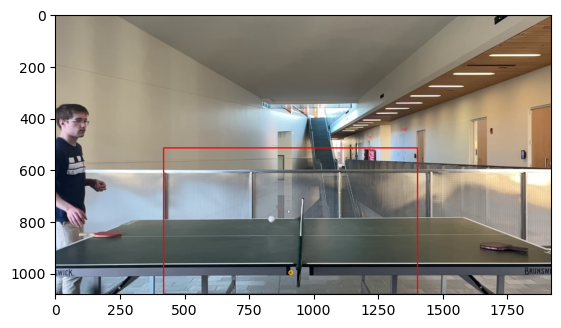

6 9
No circles found in frame 1, skipping ukf update this frame


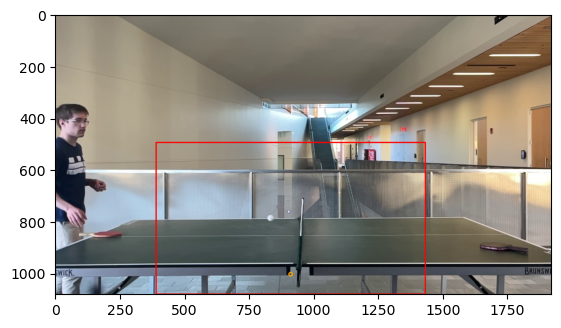

6 9
No circles found in frame 2, skipping ukf update this frame


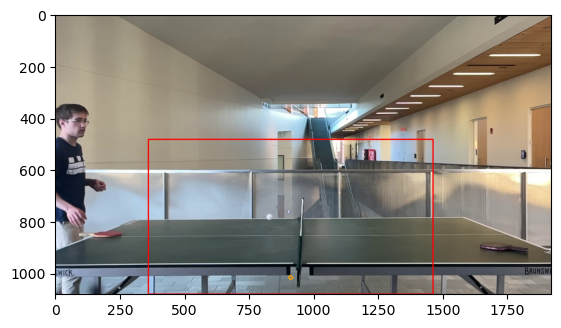

6 9
No circles found in frame 3, skipping ukf update this frame


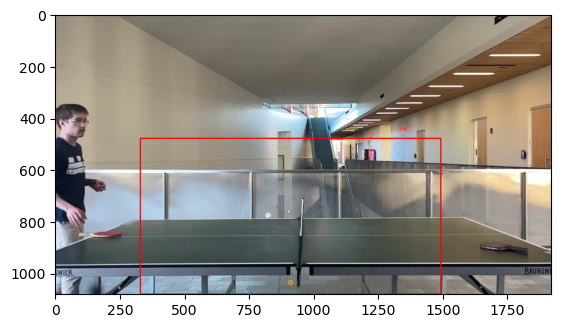

6 9
No circles found in frame 4, skipping ukf update this frame


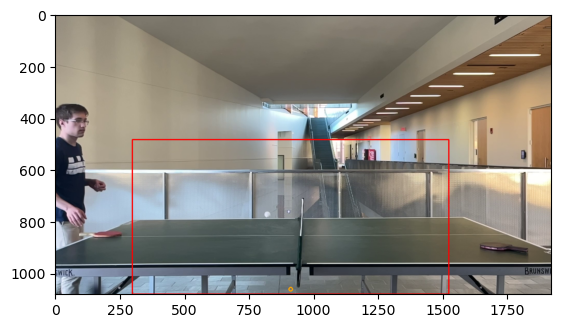

6 9
No circles found in frame 5, skipping ukf update this frame


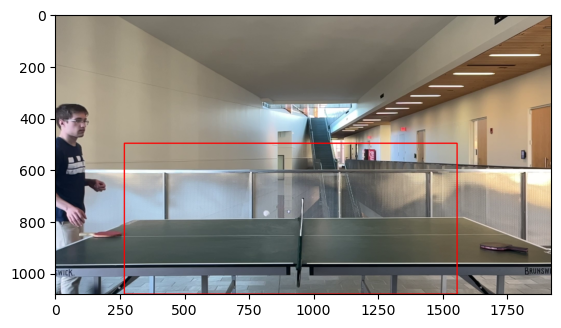

5 9
No circles found in frame 6, skipping ukf update this frame


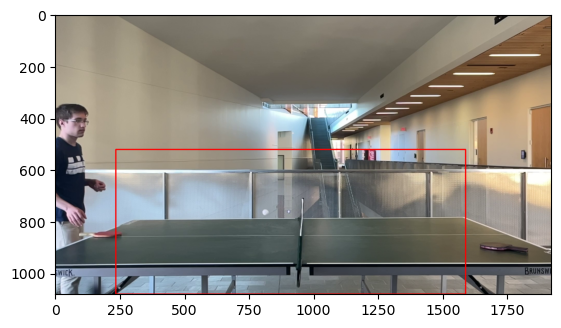

5 9
No circles found in frame 7, skipping ukf update this frame


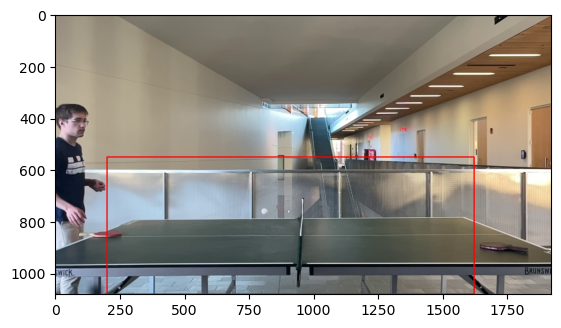

5 9
No circles found in frame 8, skipping ukf update this frame


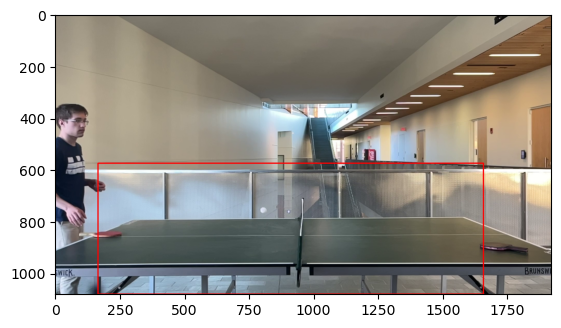

5 9
No circles found in frame 9, skipping ukf update this frame


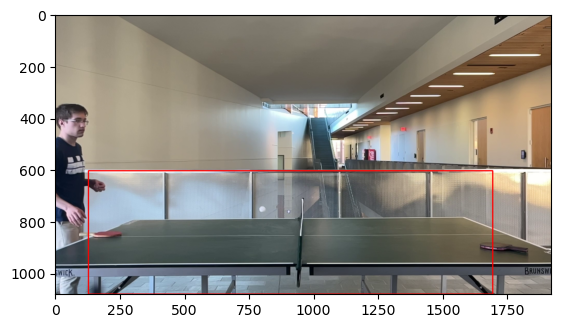

LinAlgError: 4-th leading minor of the array is not positive definite

In [21]:
dt = 1 / video.fps 
states = [ukf.state]
annotated_images = []

for i, frame in enumerate(video):

    annotated_image = frame.copy()

    # Get the high probability region in which we can find the ball    
    ukf.predict(dt)
    predicted_state = ukf.state
    likely_region = get_high_probability_region(predicted_state, ukf.state_covariance, position_estimator, video.width, video.height, standard_deviations=1)

    # Draw the ball's predicted position in orange
    predicted_projection = position_estimator.project_ball_position_table_reference_frame_to_camera_plane(predicted_state[:3])
    annotated_image = cv2.circle(annotated_image, (int(predicted_projection[0]), int(predicted_projection[1])), predicted_projection[2]//2, (0, 165, 255), 4)

    # Draw the likely region in red
    annotated_image = cv2.rectangle(annotated_image, (likely_region.x_min, likely_region.y_min), (likely_region.x_max, likely_region.y_max), (0, 0, 255), 4)

    # Detect circles in the frame
    min_radius = max(likely_region.d_min // 2, 1)
    max_radius = min(likely_region.d_max // 2, max_radius)
    print(min_radius, max_radius)

    circles = circle_detector.hough_circles(frame, min_radius, max_radius, minDist=2*min_radius, param1=50, param2=30)
    if (len(circles) == 0):
        print(f"No circles found in frame {i}, skipping ukf update this frame")
        plt.figure()
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.show()
        annotated_images.append(annotated_image)
        continue
    if (len(circles) > 1):
        circles = circle_detector.filter_to_region(frame, circles, likely_region)
    if (len(circles) > 1):
        sensitivity = 50
        lower_white = np.array([0,0,255-sensitivity])
        upper_white = np.array([255,sensitivity,255])
        circles = circle_detector.filter_circles_by_color_threshold(frame, circles, color_low_hsv=lower_white, color_high_hsv=upper_white, threshold=0.3)
    
    if len(circles) != 1:
        print(f"Found {len(circles)} circles in frame {i}, skipping ukf update this frame")

        # Draw the detected circles in green
        annotated_image = circle_detector.draw_circles(annotated_image, circles, (0, 255, 0), 1)

        plt.figure()
        plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
        plt.show()
        annotated_images.append(annotated_image)
        continue

    # Get the position of the ball
    ping_pong_ball = circles[0]
    ping_pong_ball_center_x = ping_pong_ball[0]
    ping_pong_ball_center_y = ping_pong_ball[1]
    ping_pong_ball_radius = ping_pong_ball[2]
    position = position_estimator.ball_position_table_reference_frame(ping_pong_ball_center_x, ping_pong_ball_center_y, ping_pong_ball_radius*2)

    ukf.update(position)
    states.append(ukf.state)

    # Draw the detected ball's circle in green
    cv2.circle(annotated_image, (ping_pong_ball_center_x, ping_pong_ball_center_y), ping_pong_ball_radius, (0, 255, 0), 2)
    plt.figure()
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.show()
    annotated_images.append(annotated_image)


In [ ]:
# Save the annotated images as a video
output_path = DATA_DIR / "output" / "annotated_ukf.mp4"
writer = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), video.fps, (video.width, video.height))
for image in annotated_images:
    writer.write(image)
writer.release()